In [1]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class Config:
    train_path = "../input/train.csv"
    test_path = "../input/test.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 2



In [3]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)


In [4]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [5]:
df_train = df_train.replace("欠測", np.nan)
lgb_imp = IterativeImputer(
    estimator=LGBMRegressor(num_boost_round=1000, random_state=Config.seed),
    max_iter=10,
    initial_strategy="mean",
    imputation_order="ascending",
    verbose=1,
    random_state=Config.seed,
)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)


[IterativeImputer] Completing matrix with shape (12168, 16)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Foun

[IterativeImputer] Change: 8.828120105598833, scaled tolerance: 2020033.124 
[IterativeImputer] Early stopping criterion reached.


In [6]:
# 型がfloatになってしまっているので、もどす。
df_train[["winddirection_chiba", "winddirection_tokyo"]] = (
    df_train[["winddirection_chiba", "winddirection_tokyo"]].round().astype(int)
)
df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
] = df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
].round(
    1
)
df_train["datetime"] = df_train["datetime"].astype(int)

# df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0


# Feature

In [7]:
import datetime
import re

# 時間
def to_datetime(time: datetime):
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame):
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear
    df["day_sin"] = np.sin(df["day_of_year"] * (2 * np.pi / 365))
    df["day_cos"] = np.cos(df["day_of_year"] * (2 * np.pi / 365))
    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str):
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff{lag}_"))
    # rolling
    for window in [3, 24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)


# 集計特徴
def additional_encoding(
    train: pd.DataFrame, test: pd.DataFrame, cat_col: List[str], num_col: List[str]
):

    trdf = train.copy()
    tedf = test.copy()

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf["month"] == 4) & (trdf["day"] < 15)][ccol].value_counts()
        trdf[f"ce_{ccol}"] = trdf[ccol].map(encoder)
        tedf[f"ce_{ccol}"] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ["mean", "std", "min", "max"]
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df["abs_mean"] = np.abs(agg_df["mean"])
            agg_df["min_max"] = agg_df["min"] * agg_df["max"]
            agg_df.columns = [f"{ccol}_{c}" for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how="left")
            tedf = tedf.merge(agg_df, on=ccol, how="left")

    return trdf, tedf


def add_wind_direction_to_cos_sin(df: pd.DataFrame):
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    
    """
    df_origin = df.copy()

    for col in [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / _df[col].max())
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / _df[col].max())

        _df = _df.drop(col, axis=1)

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_no_window"] = (df_origin[col] == 0).astype(int)

    return df_origin


def make_feature(df: pd.DataFrame):
    df = df.copy()
    df = time_feat(df)

    # ラグ特徴の追加
    feat = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
        "winddirection_utsunomiya",
        "winddirection_chiba",
        "winddirection_tokyo",
    ]
    df = add_lag_feat(df, feat, "year")
    df = add_wind_direction_to_cos_sin(df)

    return df



In [8]:
_df = make_feature(df_train)
_df_test = make_feature(df_test)


In [9]:
_df.iloc[_df[_df["datetime_dt"].apply(lambda x: x.day == 1)].index]


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,...,rolling24_mean_winddirection_tokyo,winddirection_utsunomiya_cos,winddirection_utsunomiya_sin,winddirection_utsunomiya_no_window,winddirection_tokyo_cos,winddirection_tokyo_sin,winddirection_tokyo_no_window,winddirection_chiba_cos,winddirection_chiba_sin,winddirection_chiba_no_window
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,...,2.000000,1.000000,-1.133108e-15,0,0.913545,4.067366e-01,0,1.000000,0.000000,0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,...,1.500000,1.000000,0.000000e+00,0,1.000000,0.000000e+00,0,1.000000,0.000000,0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,...,6.333333,1.000000,0.000000e+00,0,1.000000,-1.133108e-15,0,0.913545,-0.406737,0
3,2017020104,0.0,0.0,0.0,-1.1,4.4,1.8,1.0,15,1,...,5.000000,1.000000,0.000000e+00,0,1.000000,0.000000e+00,0,0.913545,-0.406737,0
4,2017020105,0.0,0.0,0.0,-1.2,4.1,1.5,2.0,14,14,...,6.800000,0.913545,4.067366e-01,0,0.669131,-7.431448e-01,0,0.669131,-0.743145,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11443,2020030120,0.0,0.0,0.0,10.9,11.7,12.0,4.0,4,8,...,6.458333,0.309017,9.510565e-01,0,-0.978148,2.079117e-01,0,0.309017,0.951057,0
11444,2020030121,0.0,0.0,0.0,9.5,11.5,12.2,1.0,3,6,...,6.625000,1.000000,0.000000e+00,0,-0.500000,8.660254e-01,0,0.669131,0.743145,0
11445,2020030122,0.0,0.0,0.0,8.5,11.6,11.8,2.0,3,5,...,6.791667,0.913545,4.067366e-01,0,-0.104528,9.945219e-01,0,0.669131,0.743145,0
11446,2020030123,0.0,0.0,0.0,8.2,11.3,11.6,2.0,3,5,...,6.958333,0.913545,4.067366e-01,0,-0.104528,9.945219e-01,0,0.669131,0.743145,0


# Model

In [10]:
from sklearn.metrics import mean_absolute_error


# def metric_mae(y_true, y_pred):
#    score = mean_absolute_error(y_true, y_pred)
#    return "mae", score, False


In [11]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import joblib


def train_lightgbm_with_cv(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"],
    unused_label: List[str] = ["datetime", "datetime_dt"],
    plot: bool = False,
) -> Union[np.array, List[np.float], pd.DataFrame]:

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")

        df_train = _df.loc[train_idx].reset_index(drop=True)
        df_val = _df.loc[val_idx].reset_index(drop=True)

        print(df_val[["datetime", target_label]])

        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)

        # TODO 年をまたがないようにsplitした方がよさそう
        label = target_label

        model.fit(
            df_train[cols],
            df_train[label],
            eval_set=(df_val[cols], df_val[label]),
            early_stopping_rounds=1000,
            eval_metric="mae",
            verbose=-1,
        )

        # validation
        val_pred = model.predict(df_val[cols])
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)

        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()

        prediction += (
            model.predict(_df_test[cols], num_iteration=model.best_iteration_)
            / Config.n_splits
        )

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps


In [12]:
def split_by_year(
    df: pd.DataFrame,
    date_col="datetime_dt",
    years=[2017, 2018, 2019],
    split_date_tuple=(4, 1),
):
    s_month, s_day = split_date_tuple    
    for year in years:        
        train_idx = _df[
            (df[date_col].apply(lambda x: x.year <= year))
            & (df[date_col].apply(lambda x: x < datetime.datetime(year, s_month, s_day)))
        ].index
        valid_idx = df[
            (df[date_col].apply(lambda x: x.year <= year))
            & df[date_col].apply(lambda x: x >= datetime.datetime(year, s_month, s_day))
        ].index

        yield train_idx, valid_idx


def train_lightgbm_with_split_by_year(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"],
    unused_label: List[str] = ["datetime", "datetime_dt"],
    plot: bool = False,
) -> Union[np.array, List[np.float], pd.DataFrame]:

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    # folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    for fold, (train_idx, val_idx) in enumerate(split_by_year(_df)):
        print(f"=====fold {fold}=======")

        df_train = _df.loc[train_idx].reset_index(drop=True)
        df_val = _df.loc[val_idx].reset_index(drop=True)

        print(df_val[["datetime", target_label]])

        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)

        # TODO 年をまたがないようにsplitした方がよさそう
        label = target_label

        model.fit(
            df_train[cols],
            df_train[label],
            eval_set=(df_val[cols], df_val[label]),
            early_stopping_rounds=1000,
            eval_metric="mae",
            verbose=-1,
        )

        # validation
        val_pred = model.predict(df_val[cols])
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)

        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()

        prediction += (
            model.predict(_df_test[cols], num_iteration=model.best_iteration_)
            / Config.n_splits
        )

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps


=====fold 0=======
        datetime  pollen_utsunomiya
0     2017033124                0.0
1     2017040101                0.0
2     2017040102                0.0
3     2017040103                0.0
4     2017040104                4.0
...          ...                ...
2180  2017063020                0.0
2181  2017063021                0.0
2182  2017063022                0.0
2183  2017063023                0.0
2184  2017063024                0.0

[2185 rows x 2 columns]
train shape (1415, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 61.7744	valid_0's l2: 4657.8


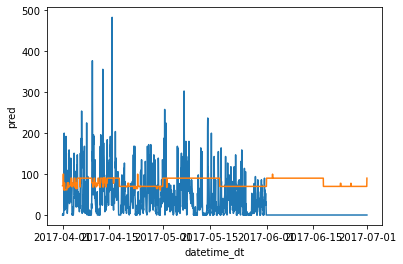

=====fold 1=======
        datetime  pollen_utsunomiya
0     2018033124              319.0
1     2018040101              245.0
2     2018040102              348.0
3     2018040103              401.0
4     2018040104              553.0
...          ...                ...
2180  2018063020                0.0
2181  2018063021                0.0
2182  2018063022                0.0
2183  2018063023                0.0
2184  2018063024                0.0

[2185 rows x 2 columns]
train shape (4991, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 99.6429	valid_0's l2: 23347.8


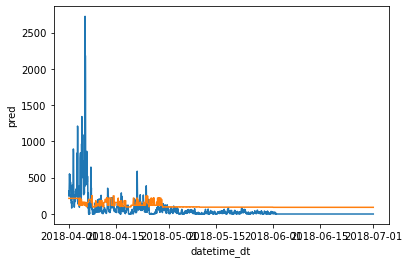

=====fold 2=======
        datetime  pollen_utsunomiya
0     2019033124                0.0
1     2019040101                0.0
2     2019040102                0.0
3     2019040103                0.0
4     2019040104                4.0
...          ...                ...
2180  2019063020                0.0
2181  2019063021                0.0
2182  2019063022                0.0
2183  2019063023                0.0
2184  2019063024                0.0

[2185 rows x 2 columns]
train shape (8567, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's l1: 68.692	valid_0's l2: 44043.3


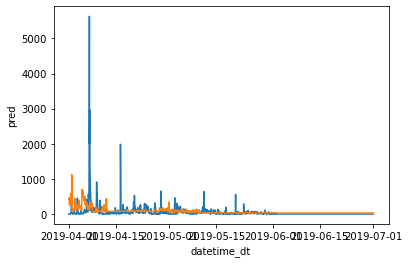

 fold_0 mae: 61.77436879457031
 fold_1 mae: 99.64286693385127
 fold_2 mae: 68.69204416919249


In [13]:
utsunomiya_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
    _df, _df_test, target_label="pollen_utsunomiya", plot=True
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")


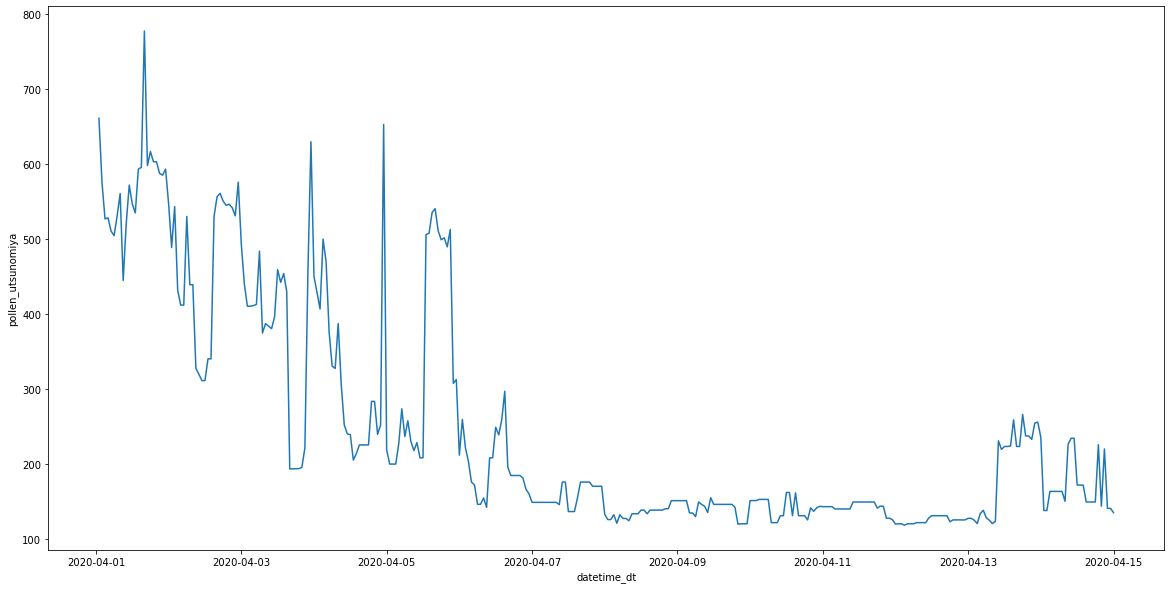

In [14]:
__df_test = _df_test.copy()
__df_test["pollen_utsunomiya"] = utsunomiya_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_utsunomiya")



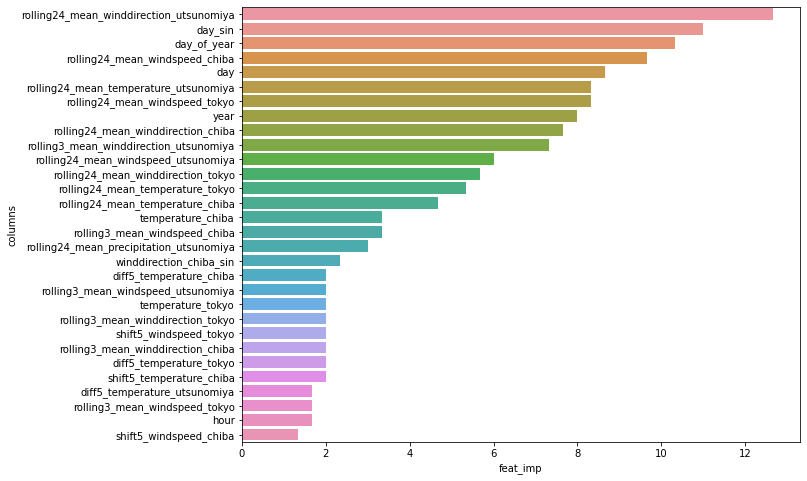

In [15]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# tokyo

=====fold 0=======
        datetime  pollen_tokyo
0     2017033124           0.0
1     2017040101           0.0
2     2017040102           0.0
3     2017040103           0.0
4     2017040104           0.0
...          ...           ...
2180  2017063020           0.0
2181  2017063021           0.0
2182  2017063022           0.0
2183  2017063023           0.0
2184  2017063024           0.0

[2185 rows x 2 columns]
train shape (1415, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 33.2853	valid_0's l2: 2150.88


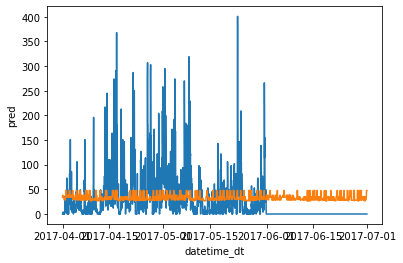

=====fold 1=======
        datetime  pollen_tokyo
0     2018033124         233.0
1     2018040101         315.0
2     2018040102         204.0
3     2018040103         204.0
4     2018040104         393.0
...          ...           ...
2180  2018063020           0.0
2181  2018063021           0.0
2182  2018063022           0.0
2183  2018063023           0.0
2184  2018063024           0.0

[2185 rows x 2 columns]
train shape (4991, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 42.3128	valid_0's l2: 4094.31


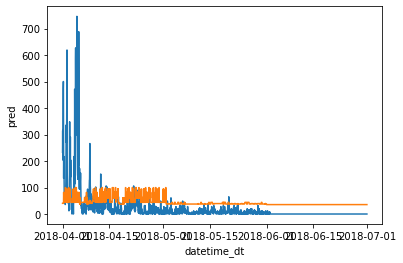

=====fold 2=======
        datetime  pollen_tokyo
0     2019033124           0.0
1     2019040101           0.0
2     2019040102           0.0
3     2019040103           0.0
4     2019040104           0.0
...          ...           ...
2180  2019063020           0.0
2181  2019063021           0.0
2182  2019063022           0.0
2183  2019063023           0.0
2184  2019063024           0.0

[2185 rows x 2 columns]
train shape (8567, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's l1: 12.8304	valid_0's l2: 485.126


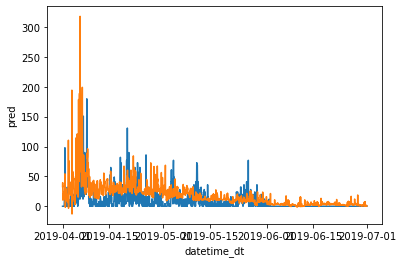

 fold_0 mae: 33.28534645346124
 fold_1 mae: 42.312805024305696
 fold_2 mae: 12.830370604458631


In [16]:
tokyo_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
    _df, _df_test, target_label="pollen_tokyo", plot=True
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")


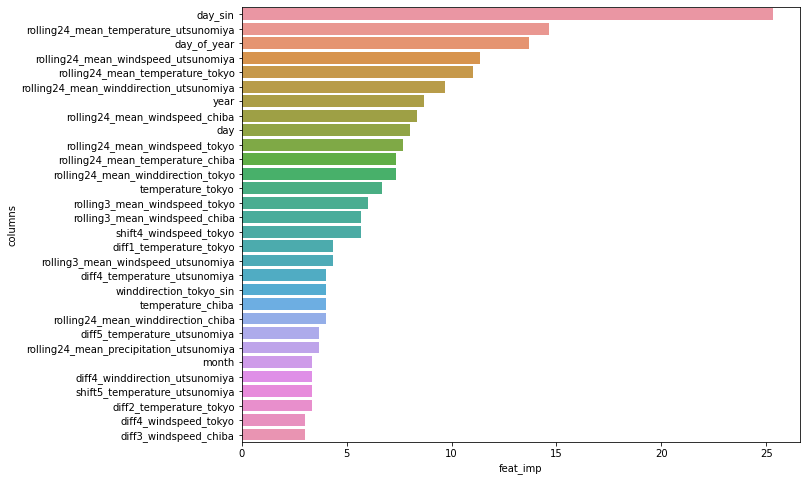

In [17]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# chiba

=====fold 0=======
        datetime  pollen_chiba
0     2017033124           0.0
1     2017040101           0.0
2     2017040102           0.0
3     2017040103           0.0
4     2017040104           0.0
...          ...           ...
2180  2017063020           0.0
2181  2017063021           0.0
2182  2017063022           0.0
2183  2017063023           0.0
2184  2017063024           0.0

[2185 rows x 2 columns]
train shape (1415, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 30.3612	valid_0's l2: 1469.86


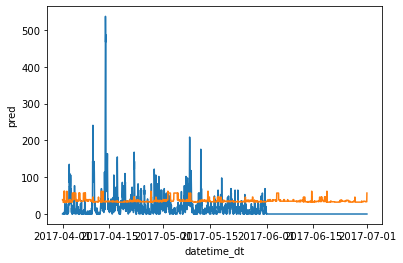

=====fold 1=======
        datetime  pollen_chiba
0     2018033124         467.0
1     2018040101         450.0
2     2018040102         537.0
3     2018040103         352.0
4     2018040104         250.0
...          ...           ...
2180  2018063020           0.0
2181  2018063021           0.0
2182  2018063022           0.0
2183  2018063023           0.0
2184  2018063024           0.0

[2185 rows x 2 columns]
train shape (4991, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 35.174	valid_0's l2: 4908.93


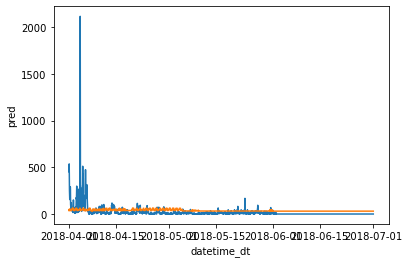

=====fold 2=======
        datetime  pollen_chiba
0     2019033124           0.0
1     2019040101           0.0
2     2019040102           0.0
3     2019040103           0.0
4     2019040104           0.0
...          ...           ...
2180  2019063020           0.0
2181  2019063021           0.0
2182  2019063022           0.0
2183  2019063023           0.0
2184  2019063024           0.0

[2185 rows x 2 columns]
train shape (8567, 178) test shape (2185, 178)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's l1: 17.5534	valid_0's l2: 963.381


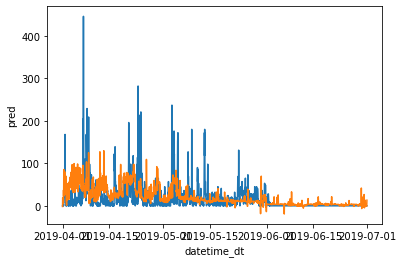

 fold_0 mae: 30.36119153957367
 fold_1 mae: 35.17396735755008
 fold_2 mae: 17.55335883186346


In [18]:
chiba_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
    _df, _df_test, target_label="pollen_chiba", plot=True
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")


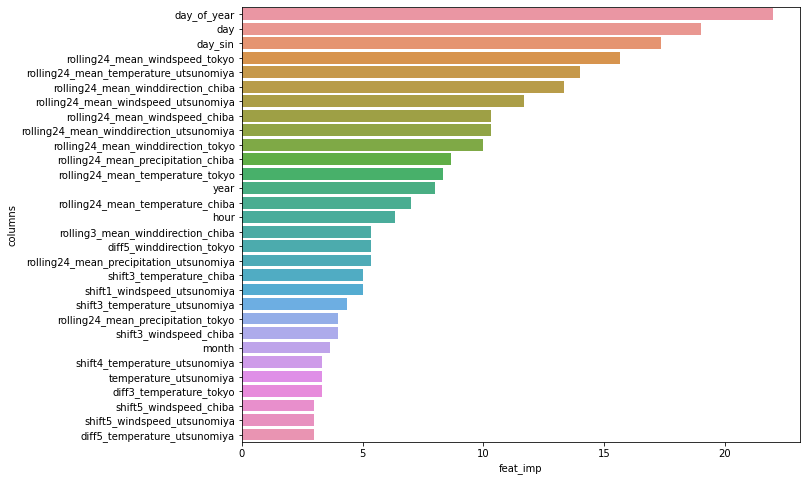

In [19]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# submission

In [20]:
df_sub = _df_test[["datetime"]]


In [21]:
df_sub["pollen_utsunomiya"] = utsunomiya_prediction
df_sub["pollen_chiba"] = chiba_prediction
df_sub["pollen_tokyo"] = tokyo_prediction


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [22]:
df_sub.head()
df_sub.to_csv(f"sub.csv", index=None)


# score
- 64.10566
- 122.26534